In [83]:
#Need to uncomment and run this when the container is first instantiated
#!apt-get install python3-opencv

In [1]:
import cv2 as cv

In [2]:
from PIL import Image
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





### Download an SSD model for face detection

In [4]:
# https://github.com/yeephycho/tensorflow-face-detection
FROZEN_GRAPH_NAME = 'data/frozen_inference_graph_face.pb'
!wget https://github.com/yeephycho/tensorflow-face-detection/blob/master/model/frozen_inference_graph_face.pb?raw=true -O {FROZEN_GRAPH_NAME}

--2020-02-23 15:08:29--  https://github.com/yeephycho/tensorflow-face-detection/blob/master/model/frozen_inference_graph_face.pb?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yeephycho/tensorflow-face-detection/raw/master/model/frozen_inference_graph_face.pb [following]
--2020-02-23 15:08:29--  https://github.com/yeephycho/tensorflow-face-detection/raw/master/model/frozen_inference_graph_face.pb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yeephycho/tensorflow-face-detection/master/model/frozen_inference_graph_face.pb [following]
--2020-02-23 15:08:30--  https://raw.githubusercontent.com/yeephycho/tensorflow-face-detection/master/model/frozen_inference_graph_face.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 

In [73]:
cv.imwrite('data/my_sample_webcam_pic.png',img)

True

### Download an image with some faces

In [29]:
# # go warriors!
# IMAGE_PATH = 'data/warriors.jpg'
# !wget 'https://cdn.vox-cdn.com/thumbor/rC0mlBATZdoDW1tEa44P6431sGc=/0x0:3683x2455/1200x800/filters:focal(1623x234:2211x822)/cdn.vox-cdn.com/uploads/chorus_image/image/63273148/usa_today_12005182.0.jpg' -O {IMAGE_PATH}

### Load the frozen graph

In [30]:
output_dir=''
frozen_graph = tf.GraphDef()
with open(os.path.join(output_dir, FROZEN_GRAPH_NAME), 'rb') as f:
  frozen_graph.ParseFromString(f.read())

### A few magical constants

In [31]:
# https://github.com/NVIDIA-AI-IOT/tf_trt_models/blob/master/tf_trt_models/detection.py
INPUT_NAME='image_tensor'
BOXES_NAME='detection_boxes'
CLASSES_NAME='detection_classes'
SCORES_NAME='detection_scores'
MASKS_NAME='detection_masks'
NUM_DETECTIONS_NAME='num_detections'

input_names = [INPUT_NAME]
output_names = [BOXES_NAME, CLASSES_NAME, SCORES_NAME, NUM_DETECTIONS_NAME]

### Optimize the frozen graph using TensorRT

In [32]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Linked TensorRT version: (6, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (6, 0, 1)
INFO:tensorflow:Running against TensorRT version 6.0.1


### Create session and load graph

In [33]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

# use this if you want to try on the optimized TensorRT graph
# Note that this will take a while
# tf.import_graph_def(trt_graph, name='')

# use this if you want to try directly on the frozen TF graph
# this is much faster
tf.import_graph_def(frozen_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

### Load and Preprocess Image

In [78]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_resized[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]

### Display Results

In [79]:
# suppress boxes that are below the threshold.. 
DETECTION_THRESHOLD = 0.5

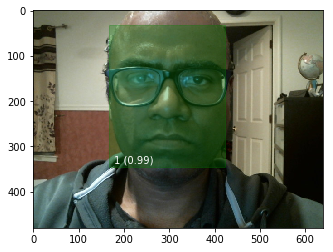

In [80]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    if scores[i] < DETECTION_THRESHOLD:
        continue
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

In [54]:
def get_images(cap):
    _ret, img = cap.read()
    if not _ret:
        print('No image')
        return
    
    img_color = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img_color)
    plt.show()
    
    image = Image.fromarray(img_color)
    image_resized = np.array(image.resize((300, 300)))
    #image_resized = np.resize(image, (300,300))
    print(image_resized.shape)
    plt.imshow(image_resized)
    plt.show()
    image = np.array(image)
    run_inference(image_resized, image)

def run_inference(image_resized, image):
    scores, boxes, classes, num_detections = tf_sess.run(
        [tf_scores, tf_boxes, tf_classes, tf_num_detections], 
                    feed_dict={ tf_input: image_resized[None, ...] })
    boxes = boxes[0] # index by 0 to remove batch dimension
    scores = scores[0]
    classes = classes[0]
    num_detections = num_detections[0]
    display_detected_images(image, boxes, scores, num_detections, classes)

def display_detected_images(image, boxes, scores, num_detections, classes):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    ax.imshow(image)
    # plot boxes exceeding score threshold
    for i in range(int(num_detections)):
        if scores[i] < DETECTION_THRESHOLD:
            continue
        # scale box to image coordinates
        box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])
        
        # display rectangle
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
        ax.add_patch(patch)
        
        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')
        
    plt.show()

In [56]:
for i in range(1):
    try:
        cap = cv.VideoCapture(0)
        get_images(cap)
    finally:
        cap.release()

No image


### Benchmark

In [81]:
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.097699 seconds


### Close session to release resources

In [16]:
tf_sess.close()